### BioNeMo DNABERT Custom Data Pretraining Demo

Note: This notebook was tested on a single `<NVIDIA RTX 5880 Ada Generation>` GPU using BioNeMo Framework `<v1.8>`, with an expected runtime of < 20 min. 

### Demo Objectives

### 1. **Data Preprocessing**
   * **Objective:** 
       * Prepare gut microbiome sequences for DNABERT pretraining by assessing data quality and performing preprocessing steps, including length distribution analysis and splitting sequences into train, validation, and test sets.
   * **Steps:**
       1. Collect gut microbiome sequences from genome assembly GCA_011262095.1.
       2. Split the sequences into training, validation, and test sets to ensure a balanced distribution.
       3. Analyze sequence length distributions in each set and calculate the total number of bases to assess data quality. If the sequences are too short, adjustments may be necessary to ensure effective pretraining.
       4. Perform preprocessing on the sequences, splitting them on 'N' characters, which denote unknown bases, to prepare the dataset for model training.

### 2. **Pre-Training DNABERT on Gut Microbiome Data**
   * **Objective:** 
       * Pre-train the DNABERT model on processed sequences from the gut microbiome dataset to learn the general patterns in microbial DNA. This will provide a robust foundation for downstream tasks like taxonomic classification.
   * **Steps:**
       1. Use the processed gut microbiome sequences (from genome assembly GCA_011262095.1) as the training dataset.
       2. Train DNABERT on these sequences, ensuring that the sequence lengths and the dataset size are adequate for learning meaningful DNA patterns.
       3. Monitor the model’s performance during pretraining, including the loss values, to ensure the model is learning the underlying patterns in microbial DNA.
       4. Save the pre-trained DNABERT model checkpoint, which will serve as the foundation for further fine-tuning tasks related to taxonomic classification or other downstream applications.
       
### 3. **Embedding Visualization and Analysis**
   * **Objective:** 
       * Visualize the embeddings generated by the pre-trained DNABERT model to explore patterns in the gut microbiome data. Use UMAP for dimensionality reduction and Seaborn for clustering to gain insights into the relationships between microbial sequences.
   * **Steps:**
       1. Generate embeddings for the test set using the pre-trained DNABERT model and `infer.py`.
       2. Apply UMAP to reduce the dimensionality of the embeddings while preserving the structure of the data.
       3. Use Seaborn to visualize the UMAP results and identify clusters in the microbial sequences.
       4. Analyze the clusters to uncover meaningful patterns or relationships within the data.

---

### **Relevance**

The human gut microbiome contains a complex network of microorganisms, with unique DNA patterns that impact health and disease. By pretraining DNABERT on these microbial sequences, we aim to capture these underlying patterns, providing a strong foundation for downstream tasks such as taxonomic classification. This preprocessing and pretraining pipeline ensures that the dataset is well-prepared, and the model is trained effectively on relevant microbial DNA sequences, setting the stage for more advanced applications in microbiome research.


### Setup

Ensure that you have read through the Getting Started section, can run the BioNeMo Framework docker container, and have configured the NGC Command Line Interface (CLI) within the container. It is assumed that this notebook is being executed from within the container.

<div style="background-color:#e7f3fe; padding: 10px;">
<strong>NOTE:</strong> Some of the cells below can generate long text output. We're using:

<pre><code>%%capture --no-display --no-stderr cell_output
</code></pre>

to suppress this output. Comment or delete this line in the cells below to restore full output.
</div>

### Import and install all required packages

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import pickle
import random
import seaborn as sns
import umap
import warnings 

from Bio import SeqIO

# To ignore warnings in your notebook or script
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Home Directory

Set the home directory as follows:

In [21]:
bionemo_home = "/workspace/bionemo"
os.environ['BIONEMO_HOME'] = bionemo_home
os.chdir(bionemo_home)

### Download Model Checkpoints

The following code will download the pretrained model dnabert-86M.nemo from the NGC registry. 

In [4]:
# # Define the NGC CLI API KEY and ORG for the model download
# # If these variables are not already set in the container, uncomment below
# # to define and set with your API KEY and ORG
# api_key = <YOUR_API_KEY>
# ngc_cli_org = <YOUR_NGC_ORG>
# # Update the environment variables 
# os.environ['NGC_CLI_API_KEY'] = api_key
# os.environ['NGC_CLI_ORG'] = ngc_cli_org

In [5]:
# Set variables and paths for model and checkpoint
model_name = "dnabert" 
model_version = "dnabert-86M" 
actual_checkpoint_name = "dnabert-86M.nemo" 
model_path = os.path.join(bionemo_home, 'models')
checkpoint_path = os.path.join(model_path, actual_checkpoint_name)
os.environ['MODEL_PATH'] = model_path

In [6]:
%%capture --no-display --no-stderr cell_output
if not os.path.exists(checkpoint_path):
    !cd /workspace/bionemo && \
    python download_artifacts.py --model_dir models --models {model_name}
else:
    print(f"Model {model_name} already exists at {model_path}.")

### 1. Data Preprocessing

Next, we will download the human gut microbiome data from the NCBI website and preprocess it to create a format compatible with BioNeMo for pre-training DNABERT. Specifically, we will use the genome assembly ASM3702284v1, a gut metagenome dataset submitted by the University of Bern in March 2024. This dataset represents a collection of microbial sequences found in the human gut. Since our focus is on pre-training DNABERT to capture general patterns in microbial DNA, we will preprocess the data by splitting sequences into contigs and ensuring they are appropriately formatted and truncated to meet DNABERT’s input requirements. 

#### Download the gut metagenome data from NCBI 

First, we need to create a directory for the data that will be used in this tutorial. 

In [22]:
base_data_dir = os.path.join(bionemo_home, "data", "gutmicrob_data")

# Checking if the directory exists
if not os.path.exists(base_data_dir):
    os.makedirs(base_data_dir)
    print(f"Created the directory: {base_data_dir}")
else:
    print(f"The directory already exists: {base_data_dir}")

The directory already exists: /workspace/bionemo/data/gutmicrob_data


Download the `datasets` command-line tool from the NCBI website.
These tools are essential for efficiently retrieving and processing genomic data.
The `datasets` tool is used to download various types of biological data, including genomes, genes, and sequences, directly from NCBI.
In this case, we'll use the tool to download the gut metagenome data from the NCBI database.
The data retrieved can include whole genome sequences, annotations, and other relevant biological information. 

In [23]:
!curl -o datasets 'https://ftp.ncbi.nlm.nih.gov/pub/datasets/command-line/v2/linux-amd64/datasets'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.0M  100 22.0M    0     0  12.0M      0  0:00:01  0:00:01 --:--:-- 12.0M


In [24]:
!chmod +x datasets

In [25]:
# Defining the genome accession number and base directory
genome_accession = "GCA_011262095.1"

downloaded_file = os.path.join(base_data_dir, "ncbi_dataset.zip")
extract_dir = os.path.join(base_data_dir, "ncbi_dataset")

if not os.path.exists(downloaded_file):
    print(f"Dataset not found locally. Downloading dataset for accession: {genome_accession}")
    # Downloading the dataset using the 'datasets' tool
    !./datasets download genome accession {genome_accession} --include gff3,rna,cds,protein,genome,seq-report --filename {downloaded_file}
else:
    print(f"Dataset already downloaded at: {downloaded_file}")

if not os.path.exists(extract_dir):
    print(f"Extracting dataset from {downloaded_file} to {extract_dir}")
    !unzip -o {downloaded_file} -d {extract_dir}
    print(f"Extracted the dataset to: {extract_dir}")
else:
    print(f"Dataset already extracted at: {extract_dir}")


Dataset already downloaded at: /workspace/bionemo/data/gutmicrob_data/ncbi_dataset.zip
Dataset already extracted at: /workspace/bionemo/data/gutmicrob_data/ncbi_dataset


#### Checking the number of sequences in the .fna file  

In [26]:
input_fasta = os.path.join(base_data_dir, "ncbi_dataset", "ncbi_dataset", "data", "GCA_011262095.1", "GCA_011262095.1_ASM1126209v1_genomic.fna")

# Counting the number of sequences in the .fna file
num_sequences = sum(1 for _ in SeqIO.parse(input_fasta, "fasta"))

print(f"Number of sequences in the file: {num_sequences}")

Number of sequences in the file: 1069


#### Splitting fasta file into train, test, and val for next steps 

In [27]:
# Output file paths for train, val, and test sets
train_fasta = os.path.join(base_data_dir, "train_sequences.fna")
val_fasta = os.path.join(base_data_dir, "val_sequences.fna")
test_fasta = os.path.join(base_data_dir, "test_sequences.fna")

def split_fasta(input_fasta, train_fasta, val_fasta, test_fasta, train_frac=0.7, val_frac=0.15):
    """
    Splits a FASTA file into train, validation, and test sets.

    Args:
        input_fasta (str): Path to input FASTA file.
        train_fasta (str): Path to output training FASTA file.
        val_fasta (str): Path to output validation FASTA file.
        test_fasta (str): Path to output test FASTA file.
        train_frac (float): Fraction of the data to be used for training.
        val_frac (float): Fraction of the data to be used for validation.
    """
    # Read all sequences from the input FASTA file
    records = list(SeqIO.parse(input_fasta, "fasta"))
    random.shuffle(records)  # Shuffle the sequences for randomness
    
    # Calculate the sizes of each set
    train_size = int(len(records) * train_frac)
    val_size = int(len(records) * val_frac)

    # Split the records into train, val, and test sets
    train_records = records[:train_size]
    val_records = records[train_size:train_size + val_size]
    test_records = records[train_size + val_size:]

    # Write the records to the respective output FASTA files
    SeqIO.write(train_records, train_fasta, "fasta")
    SeqIO.write(val_records, val_fasta, "fasta")
    SeqIO.write(test_records, test_fasta, "fasta")

    print(f"Train sequences saved to {train_fasta}")
    print(f"Validation sequences saved to {val_fasta}")
    print(f"Test sequences saved to {test_fasta}")

# Run the split function
split_fasta(input_fasta, train_fasta, val_fasta, test_fasta)

Train sequences saved to /workspace/bionemo/data/gutmicrob_data/train_sequences.fna
Validation sequences saved to /workspace/bionemo/data/gutmicrob_data/val_sequences.fna
Test sequences saved to /workspace/bionemo/data/gutmicrob_data/test_sequences.fna


### Sequence Distribution Analysis

In this step, we analyze the length distribution and the total number of bases in the train, validation, and test sets of gut microbiome DNA sequences. By plotting histograms of sequence lengths, we visualize how many sequences fall within certain length ranges, which is critical for ensuring that sequences are long enough to be useful in model pretraining. Short sequences may not provide enough context for DNABERT to learn meaningful patterns, which could affect model performance during pretraining.

Additionally, we calculate the total number of bases in each dataset (train, validation, and test). This helps in estimating the overall dataset size and understanding whether the amount of data is sufficient for pretraining. The balance between the total number of bases across the datasets is also important, as uneven distribution could lead to biased learning during model training. This statistical analysis provides insights into how well the dataset is prepared for the upcoming pretraining tasks.

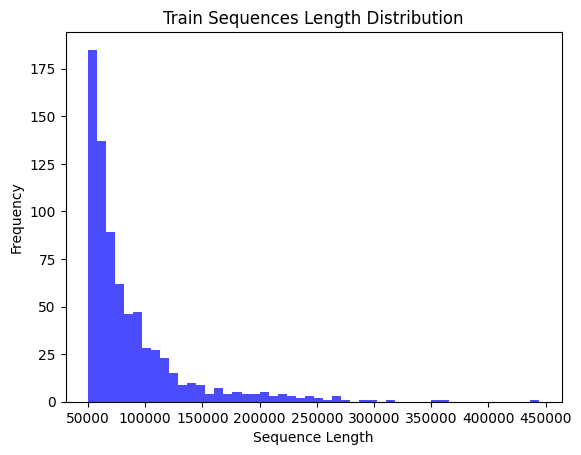

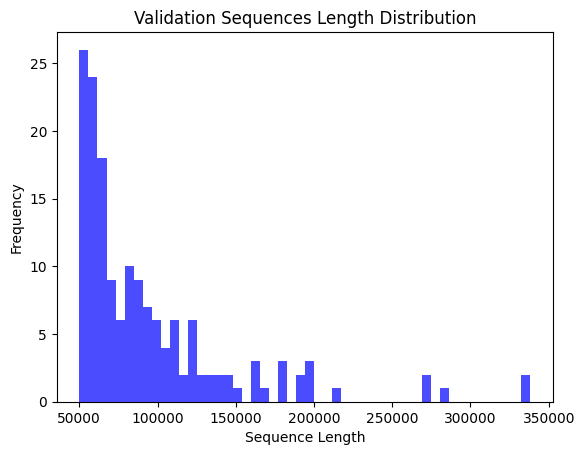

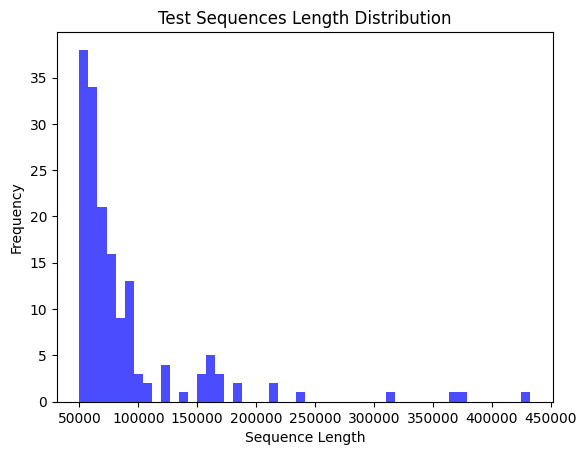

Total bases in train set: 65064798
Total bases in validation set: 15036068
Total bases in test set: 14194478


In [28]:
def plot_length_distribution(fasta_file, title):
    """
    Plot the length distribution of sequences in a FASTA file.
    Args:
        fasta_file (str): Path to the FASTA file.
        title (str): Title for the plot.
    Returns:
        lengths (list): List of sequence lengths.
    """
    lengths = [len(record.seq) for record in SeqIO.parse(fasta_file, "fasta")]
    
    # Plot the histogram of sequence lengths
    plt.hist(lengths, bins=50, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.show()

    # Return the lengths for further analysis
    return lengths

def calculate_total_bases(lengths):
    """
    Calculate the total number of bases in a list of sequence lengths.
    Args:
        lengths (list): List of sequence lengths.
    Returns:
        total_bases (int): Total number of bases.
    """
    total_bases = sum(lengths)
    return total_bases

# Plot the length distribution and calculate total bases for each dataset
train_lengths = plot_length_distribution(train_fasta, "Train Sequences Length Distribution")
val_lengths = plot_length_distribution(val_fasta, "Validation Sequences Length Distribution")
test_lengths = plot_length_distribution(test_fasta, "Test Sequences Length Distribution")

# Calculate total number of bases in each set
total_bases_train = calculate_total_bases(train_lengths)
total_bases_val = calculate_total_bases(val_lengths)
total_bases_test = calculate_total_bases(test_lengths)

# Print total bases
print(f"Total bases in train set: {total_bases_train}")
print(f"Total bases in validation set: {total_bases_val}")
print(f"Total bases in test set: {total_bases_test}")

#### Running the Preprocessing Script:

To preprocess your FASTA files, you can specify each file directly as shown below.

If you have mutliple fasta files in train/test/val, you can use a command like: 
```bash
python mydata/custom_fastas_preprocess.py data/gutmicrob_data/train/*.fasta data/gutmicrob_data/val/*.fasta data/gutmicrob_data/test/*.fasta --output_dir data/gutmicrob_data/processed_fasta


#### Preprocessing Genomic Data with Custom FASTA Splitting 

The `custom_fastas_preprocess.py` script preprocesses genomic datasets by splitting sequences in FASTA files based on 'N' characters, which represent unknown bases. The key steps are:

1. **Create Output Directories**: Ensures `train`, `val`, and `test` directories exist for processed files. If not, they are created automatically.

2. **Process FASTA Files**: Reads each input FASTA file and splits the sequences at 'N' characters. This helps to handle large or fragmented sequences by treating parts separated by 'N' as distinct sequences.

3. **Save Processed Files**: The split sequences are saved into the respective `train`, `val`, and `test` directories with updated filenames. The script prints the paths to the new files.

This process enables efficient handling of genomic data for downstream tasks like DNABERT pretraining.

In [13]:
!python /workspace/bionemo/examples/dna/dnabert/scripts/custom_fastas_preprocess.py /workspace/bionemo/data/gutmicrob_data/train_sequences.fna /workspace/bionemo/data/gutmicrob_data/val_sequences.fna /workspace/bionemo/data/gutmicrob_data/test_sequences.fna --output_dir /workspace/bionemo/data/gutmicrob_data/processed_fasta

Created directory: /workspace/bionemo/data/gutmicrob_data/processed_fasta/train
Created directory: /workspace/bionemo/data/gutmicrob_data/processed_fasta/val
Created directory: /workspace/bionemo/data/gutmicrob_data/processed_fasta/test
Processing file: /workspace/bionemo/data/gutmicrob_data/train_sequences.fna
Generated new file: /workspace/bionemo/data/gutmicrob_data/train_sequences.fna.chunked.fa
Processed file saved to /workspace/bionemo/data/gutmicrob_data/processed_fasta/train/train_sequences.fna.chunked.fa
Processing file: /workspace/bionemo/data/gutmicrob_data/val_sequences.fna
Generated new file: /workspace/bionemo/data/gutmicrob_data/val_sequences.fna.chunked.fa
Processed file saved to /workspace/bionemo/data/gutmicrob_data/processed_fasta/val/val_sequences.fna.chunked.fa
Processing file: /workspace/bionemo/data/gutmicrob_data/test_sequences.fna
Generated new file: /workspace/bionemo/data/gutmicrob_data/test_sequences.fna.chunked.fa
Processed file saved to /workspace/bionemo/

### 2. Pretraining DNABert on Gut Microbiome Data

In [29]:
config_dir = os.path.join(bionemo_home, 'examples', 'dna', 'dnabert', 'conf')
processed_pretraining_data = os.path.join(base_data_dir, "processed_fasta")
train_fasta = os.path.join(processed_pretraining_data, "train", "train_sequences.fna.chunked.fa")
val_fasta = os.path.join(processed_pretraining_data, "val", "val_sequences.fna.chunked.fa")
test_fasta = os.path.join(processed_pretraining_data, "test", "test_sequences.fna.chunked.fa")
index_mapping_dir = os.path.join(base_data_dir, "index_mapping_dir")
os.makedirs(index_mapping_dir, exist_ok=True)

#### Before launching the pretraining script

If you have previously run this script, it’s important to ensure that all `.idx` files are deleted from the following directories:

- `data/gutmicrob_data/processed_fasta/test`
- `data/gutmicrob_data/processed_fasta/val`
- `data/gutmicrob_data/processed_fasta/train`

When running pretraining tasks, certain memory-mapping index files (.idx files) are automatically generated by the system during the first run. These index files provide a more memory-efficient way to access the dataset, avoiding the need to load the entire dataset into memory, especially when dealing with large genomic datasets. However, these files can cause issues if you modify the dataset while keeping the same file names and paths. This is because the index files created during the first run are specific to the original dataset structure.

If you overwrite your dataset or change the contents (e.g., altering sequence lengths or replacing sequences), but leave the index files intact, they will no longer align with the modified dataset. As a result, you may encounter errors during the second run of the pretraining script, as the system will attempt to use the old index files, which no longer correspond to the updated dataset.

To prevent this issue and ensure a smooth execution of the pretraining script, it's essential to delete the .idx files from the dataset directories before starting a new run. By doing so, the model will generate new index files that accurately reflect the current structure and content of the dataset.


In [30]:
! rm -rf {index_mapping_dir}

In [ ]:
! cd /workspace/bionemo && python examples/dna/dnabert/pretrain.py \
    --config-path=/workspace/bionemo/examples/dna/dnabert/conf \
    --config-name=dnabert_xsmall \
    ++trainer.devices=1 \
    ++trainer.max_steps=1 \
    ++trainer.val_check_interval=1 \
    ++model.data.index_mapping_dir={index_mapping_dir} \
    ++model.data.dataset_path={processed_pretraining_data} \
    ++model.data.dataset.train=train_sequences.fna.chunked.fa \
    ++model.data.dataset.val=val_sequences.fna.chunked.fa \
    ++model.data.dataset.test=test_sequences.fna.chunked.fa \
    ++exp_manager.create_wandb_logger=false

### 3. Embedding Visualization and Analysis 

Now, once we have pretrained on our custom dataset, we are generating embeddings from the pre-trained DNABERT model to visualize the relationships between gut microbiome sequences. By reducing the dimensionality of these embeddings using UMAP and plotting them with Seaborn, we aim to uncover patterns and clusters in the data, helping us better understand the structure of the microbial sequences.

To conduct inference, we need to convert the fasta file of the sequences to a BioNeMo compatible CSV format, which consists of a column for an index and a column containing sequence strings.  For DNABERT, the maximum sequence length should be 512 tokens, as the model is based on the BERT architecture, which has this limitation. If any sequences exceed a length of 512 or are less than 512, they need to be truncated to fit within this limit.

In [32]:
input_test_fasta = "/workspace/bionemo/data/gutmicrob_data/processed_fasta/test/test_sequences.fna.chunked.fa"

# Output CSV file with a clear name for inference
preprocessed_for_inference_test = "/workspace/bionemo/data/gutmicrob_data/processed_fasta/test_sequences_preprocessed.csv"

# Setting the maximum sequence length
max_seq_len = 512

# Using SeqIO to parse the sequences and truncate them to 512 nucleotides
sequence_dict = {}
for record in SeqIO.parse(input_test_fasta, "fasta"):
    truncated_seq = str(record.seq)[:max_seq_len]
    if len(truncated_seq) == max_seq_len:
        sequence_dict[record.id] = truncated_seq

# Creating a DataFrame with original IDs and truncated sequences
df = pd.DataFrame(sequence_dict.items(), columns=['id', 'sequence'])

# Saving the DataFrame to a CSV file after processing
df.to_csv(preprocessed_for_inference_test, index=False)

print(f"Total number of sequences with length {max_seq_len}: {len(df)}")
print(f"Processed data saved to: {preprocessed_for_inference_test}")

Total number of sequences with length 512: 161
Processed data saved to: /workspace/bionemo/data/gutmicrob_data/processed_fasta/test_sequences_preprocessed.csv


In [33]:
output_dir = os.path.join(base_data_dir, "inference_output")
inference_results = os.path.join(output_dir, "dnabert_inference_results.pkl")
! mkdir -p {output_dir}

In [ ]:
! python /workspace/bionemo/bionemo/model/infer.py \
    --config-dir {config_dir} \
    --config-name infer \
    ++name=DNABERT_Inference \
    ++model.downstream_task.restore_path=/workspace/bionemo/results/nemo_experiments/dnabert/dnabert-xsmall/checkpoints/dnabert.nemo \
    ++model.data.dataset_path={preprocessed_for_inference_test} \
    ++model.inference_output_file={inference_results} \
    ++model.data.output_fname={inference_results} \
    ++model.downstream_task.outputs=[embeddings] \
    ++trainer.precision=32 \
    ++trainer.devices=1 \
    ++exp_manager.exp_dir={output_dir}

Now, we will use UMAP to reduce the dimensionality of the embeddings generated from the pre-trained DNABERT model. This step helps us visualize the relationships between sequences, and Seaborn is used to create a scatter plot that reveals potential clusters or patterns in the data.

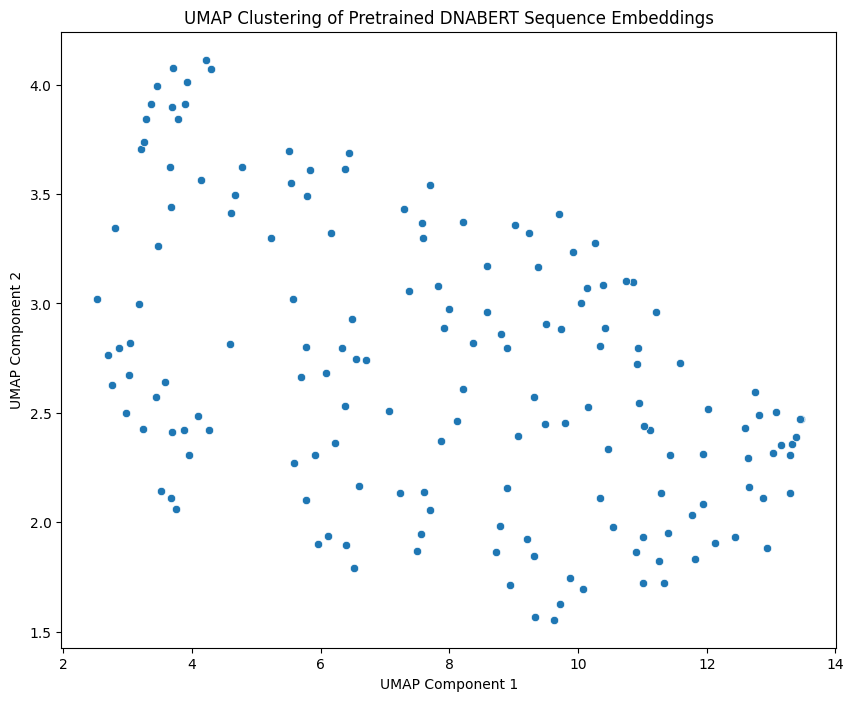

In [35]:
with open(inference_results, "rb") as f:
    inference_results_data = pickle.load(f)

# Extracting embeddings from each dictionary in the list
embeddings = np.array([item['embeddings'] for item in inference_results_data])

# Applying UMAP for dimensionality reduction to 2 components
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], palette="viridis", legend=None)
plt.title('UMAP Clustering of Pretrained DNABERT Sequence Embeddings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In this tutorial, you pre-trained the DNABERT model on a custom gut microbiome dataset, preparing the sequences through data preprocessing and splitting them into train, validation, and test sets. After pretraining, you generated embeddings from the DNABERT model and visualized the relationships between these sequences using UMAP and Seaborn, uncovering patterns and clusters within the microbial data.